**This notebook contains the code and output of training and validation done by me. At the end, I have also added code that would load the model and do validation, which can be used by the evaluators**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os


**Loading the dataset**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

train_dir = '/content/drive/My Drive/WBC_10_plain/data'
val_dir = '/content/drive/My Drive/dataset/WBC_100/val/data'

# Image dimensions
img_width, img_height = 575, 575


# Define data transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

# Load data from the 'train' directory
train_data = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

# Load data from the 'val' directory
val_data = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_data, batch_size=4)



In [ ]:
tl = len(train_loader.dataset)
print("Length of the dataset:", tl)

vl = len(val_loader.dataset)
print("Length of the dataset:", vl)


Length of the dataset: 842
Length of the dataset: 1728


**Defining the class for the model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the basic residual block
class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Define the CNN model with two residual blocks
class ResNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicResidualBlock, 64, 2)
        self.layer2 = self._make_layer(BasicResidualBlock, 128, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 5)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Initialize the model
net = ResNet()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()


In [ ]:

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create an instance of the My_CNN and move it to the GPU if available
net = ResNet().to(device)

# Define loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)

batch_size = 4



**Training Loop**

In [ ]:
# Training loop
num_epochs = 20
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []
best_test_accuracy = 0.0
best_model_path = 'my_wbc_10_plain_model.pth'

for epoch in range(num_epochs):
    print("started epoch: ", epoch)
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        #print("processing batch")
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = (correct / total) * 100
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(val_loader)
    test_accuracy = (correct / total) * 100
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    if test_accuracy > best_test_accuracy:
        # Save the model with the best weights
        best_test_accuracy = test_accuracy
        torch.save(net.state_dict(), best_model_path)
        print(f"Best model saved to {best_model_path}")

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Loss: {test_loss:.4f} - Val Acc: {test_accuracy:.2f}%')

#torch.save(net.state_dict(), 'my_wbc_10.pth')

started epoch:  0
Best model saved to my_wbc_10_plain_model.pth
Epoch [1/20] - Train Loss: 1.0605 - Train Acc: 59.98% - Val Loss: 1.1318 - Val Acc: 61.52%
started epoch:  1
Best model saved to my_wbc_10_plain_model.pth
Epoch [2/20] - Train Loss: 0.9713 - Train Acc: 62.11% - Val Loss: 1.0552 - Val Acc: 62.27%
started epoch:  2
Best model saved to my_wbc_10_plain_model.pth
Epoch [3/20] - Train Loss: 0.8675 - Train Acc: 64.73% - Val Loss: 1.0741 - Val Acc: 63.83%
started epoch:  3
Best model saved to my_wbc_10_plain_model.pth
Epoch [4/20] - Train Loss: 0.8521 - Train Acc: 65.08% - Val Loss: 0.9184 - Val Acc: 65.57%
started epoch:  4
Best model saved to my_wbc_10_plain_model.pth
Epoch [5/20] - Train Loss: 0.7638 - Train Acc: 69.36% - Val Loss: 0.9458 - Val Acc: 68.81%
started epoch:  5
Best model saved to my_wbc_10_plain_model.pth
Epoch [6/20] - Train Loss: 0.7394 - Train Acc: 71.62% - Val Loss: 0.7077 - Val Acc: 75.12%
started epoch:  6
Epoch [7/20] - Train Loss: 0.6175 - Train Acc: 78.15

In [ ]:
print(train_loss_history)
print(test_loss_history)
print(train_accuracy_history)
print(test_accuracy_history)

[1.0605473130658905, 0.971347561662231, 0.8674779798464752, 0.8520597946163603, 0.763756038029612, 0.7394152767426595, 0.6175210949086465, 0.6187481515780444, 0.5808943862457411, 0.5521015203182731, 0.4592238357246487, 0.44266524275332264, 0.4347166491063285, 0.4275897049932118, 0.3575095216659785, 0.38758234338949643, 0.3717217386492762, 0.3025885086961232, 0.3238608998409803, 0.3768143251944351]
[1.1317971861178564, 1.0551623837651547, 1.0740636459258557, 0.9184393297904602, 0.9457646459341049, 0.7076746238464559, 0.7108531650242016, 0.5062490679179232, 0.8775051655765209, 0.5602292622853484, 0.8292424523450016, 0.43741399892260907, 0.36923045975264457, 0.40973379778302776, 0.7038636391538333, 0.4913868336987906, 0.3906990252903092, 0.32018961934833595, 0.7094856158359848, 0.5529674349179712]
[59.97624703087886, 62.11401425178147, 64.7268408551069, 65.08313539192399, 69.35866983372921, 71.61520190023754, 78.14726840855107, 77.90973871733968, 79.21615201900238, 80.9976247030879, 83.72

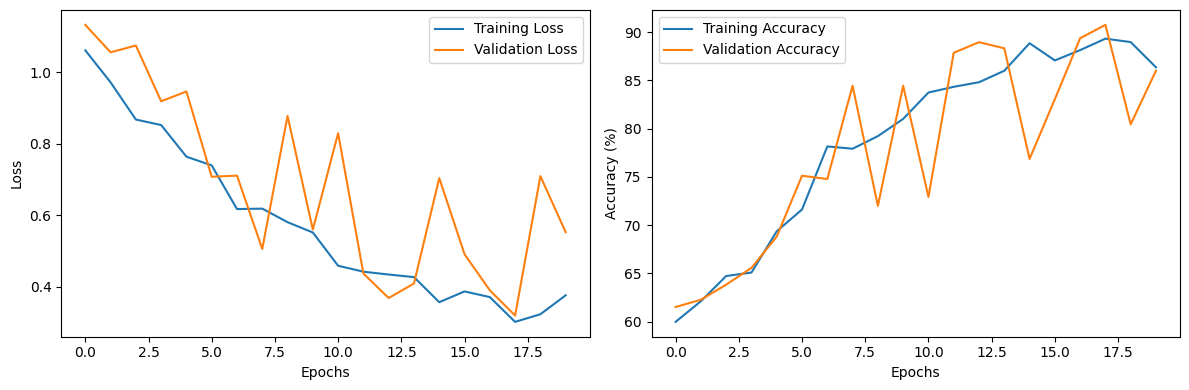

In [ ]:
# Save and display training and testing statistics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss_history, label='Training Loss')
plt.plot(range(num_epochs), test_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracy_history, label='Training Accuracy')
plt.plot(range(num_epochs), test_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

**Validation done by me**

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
print("doing val")
    # Perform validation after all epochs
net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    true_labels = []
    predicted_labels = []

    for inputs, labels in val_loader:
        #print("inside val batch")
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels for F1 score
        true_labels += labels.tolist()
        predicted_labels += predicted.tolist()

    # Calculate F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calculate overall accuracy
    correct_predictions = (np.array(true_labels) == np.array(predicted_labels)).sum()
    total_predictions = len(true_labels)
    overall_accuracy = 100 * correct_predictions / total_predictions

    # Calculate and store the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Print metrics for the final validation
    print('Final Validation Metrics:')
    print(f'Validation Accuracy: {overall_accuracy:.2f}%')
    print(f'F1 Score: {f1:.2f}')

    # Print the confusion matrix for the final validation
    print('Confusion Matrix (Final Validation):')
    print(confusion)

doing val
Final Validation Metrics:
Validation Accuracy: 86.00%
F1 Score: 0.84
Confusion Matrix (Final Validation):
[[  28    0    5    3    0]
 [   0   11   45   17   53]
 [   0    2  359   12   39]
 [   0    1   23   69    2]
 [   0    1   31    8 1019]]


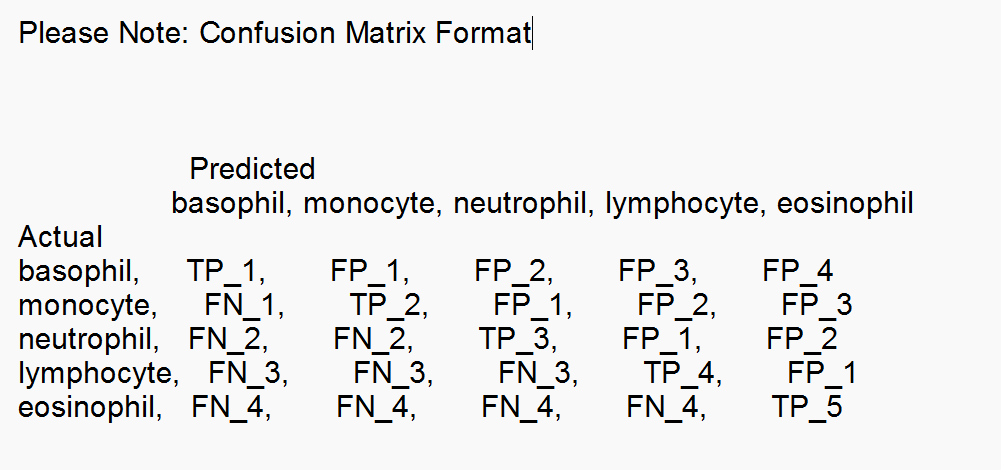

**Class-wise Detailed Report**

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=train_data.classes)

In [ ]:
print(report)

              precision    recall  f1-score   support

    Basophil       1.00      0.78      0.88        36
  Eosinophil       0.73      0.09      0.16       126
  Lymphocyte       0.78      0.87      0.82       412
    Monocyte       0.63      0.73      0.68        95
  Neutrophil       0.92      0.96      0.94      1059

    accuracy                           0.86      1728
   macro avg       0.81      0.68      0.69      1728
weighted avg       0.86      0.86      0.84      1728



**Validation code for evaluators**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
val_dir = '/content/drive/My Drive/dataset/WBC_100/val/data'  # I am reading from my google drive, kindly change the path

img_width, img_height = 575, 575
transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

val_data = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_data, batch_size=4)

In [ ]:

class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicResidualBlock, 64, 2)
        self.layer2 = self._make_layer(BasicResidualBlock, 128, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 5)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

net = ResNet()

criterion = nn.CrossEntropyLoss()


In [ ]:
state_dict_a = torch.load('/content/drive/My Drive/my_wbc_10_plain_model.pth') #kindly change the model path. this would be in the sub-folder 'models/ wbc plain without additional info'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = ResNet().to(device)

net.load_state_dict(state_dict_a)

net.eval()

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
print("doing val")
    # Perform validation after all epochs
net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    true_labels = []
    predicted_labels = []

    for inputs, labels in val_loader:
        #print("inside val batch")
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels for F1 score
        true_labels += labels.tolist()
        predicted_labels += predicted.tolist()

    # Calculate F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calculate overall accuracy
    correct_predictions = (np.array(true_labels) == np.array(predicted_labels)).sum()
    total_predictions = len(true_labels)
    overall_accuracy = 100 * correct_predictions / total_predictions

    # Calculate and store the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Print metrics for the final validation
    print('Final Validation Metrics:')
    print(f'Validation Accuracy: {overall_accuracy:.2f}%')
    print(f'F1 Score: {f1:.2f}')

    # Print the confusion matrix for the final validation
    print('Confusion Matrix (Final Validation):')
    print(confusion)

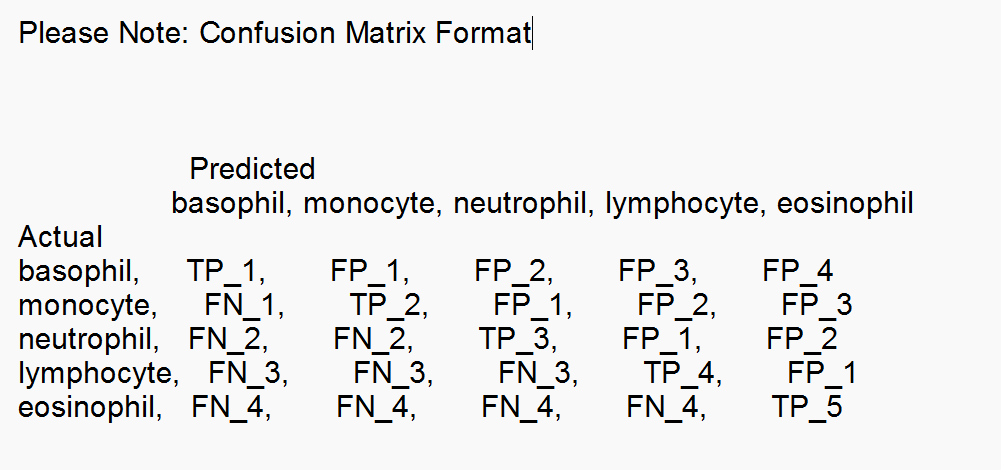

**Class-wise Detailed Report**

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=train_data.classes)
print(report)